In [1]:
import sys
sys.path.append("../") 

from src.utils.driver import set_seed
from src.utils.model import MLP, MLP_HS
from src.utils.dataset import modular_addition_dataset, ToyDataset, split_dataset

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

seed = 57
set_seed(57)
device = 'cuda'

In [2]:
vocab_size = 31
embd_dim = 16
input_token = 2
data_size = 1000
n_exp = 1
dataset = modular_addition_dataset(p=31, num=data_size, seed=seed, device=device)
dataset = split_dataset(dataset, train_ratio=0.8, seed=seed)

batch_size = 32
train_dataset = ToyDataset(dataset['train_data_id'], dataset['train_label'])
test_dataset = ToyDataset(dataset['test_data_id'], dataset['test_label'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
patience = 100
min_delta = 1e-4
counter = 0

num_epochs = 500

In [4]:
def train_gif(model, path_prefix):
    optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.01)
    lamb_reg = 0.01

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_correct = 0
        train_total = 0
        for batch_inputs, batch_targets in train_dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.type(torch.LongTensor).to(device)
            optimizer.zero_grad()
            outputs = model.forward(batch_inputs)

            criterion = nn.CrossEntropyLoss()#weight=class_weights)
            if 'harmonic' in path_prefix: # Harmonic Model
                loss = (-1)*(outputs[torch.arange(outputs.size(0)), batch_targets.squeeze()].mean())
            else:
                loss = criterion(outputs, batch_targets.squeeze())
            
            if hasattr(model.embedding, 'weight'):
                total_loss = loss + lamb_reg * torch.mean(torch.sqrt(torch.mean(model.embedding.weight**2, dim=0)))
            else:
                total_loss = loss + lamb_reg * torch.mean(torch.sqrt(torch.mean(model.embedding.data**2, dim=0)))
            
            total_loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == batch_targets).sum().item()
            train_total += batch_targets.size(0)

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"../results/mnist_vis/{path_prefix}_modadd_{epoch+1}.pt")

### H_MLP

In [5]:
weight_tied = True
hidden_size = 100
shp = [input_token * embd_dim, hidden_size, embd_dim, vocab_size]
model = MLP_HS(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, weight_tied=weight_tied, seed=seed, n=n_exp, init_scale=1).to(device)
train_gif(model, path_prefix="harmonic")

100%|██████████| 500/500 [01:56<00:00,  4.30it/s] 


### Standard MLP

In [6]:
unembd = True
weight_tied = True
hidden_size = 100
shp = [input_token * embd_dim, hidden_size, embd_dim, vocab_size]
model = MLP(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, unembd=unembd, weight_tied=weight_tied, seed=seed, init_scale=1).to(device)
train_gif(model, path_prefix="standard")

100%|██████████| 500/500 [00:20<00:00, 24.12it/s]


In [ ]:
import imageio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
from matplotlib.colors import LogNorm

weight_images = []
plt.rcParams.update({'font.size': 22})
prev_standard_pca = None
prev_harmonic_pca = None

for i in range(10, 501, 10):
    weight_standard = torch.load(f"../results/mnist_vis/standard_modadd_{i}.pt")
    weight_harmonic = torch.load(f"../results/mnist_vis/harmonic_modadd_{i}.pt")

    mnist_standard = torch.load(f"../results/mnist_vis/standard_mnist_{i}.pt")
    weights_mnist_standard = (mnist_standard['fc1.weight'].detach().cpu().numpy())[7].reshape(28, 28)
#    weights_mnist_standard = np.where(weights_mnist_standard < 0.01, 1, 0)
    
    mnist_harmonic = torch.load(f"../results/mnist_vis/harmonic_mnist_{i}.pt")
    weights_mnist_harmonic = np.abs(mnist_harmonic['fc1.weight'].detach().cpu().numpy())[7].reshape(28,28)
#    weights_mnist_harmonic = np.where(weights_mnist_harmonic < 0.01, 1, 0)

    plt.subplots(2, 2, figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.title(f"Standard: Modular Addition")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([])
    plt.yticks([])

    pca = PCA(n_components=2)
    standard_pca = pca.fit_transform(weight_standard['embedding'].cpu().detach().numpy())

    if i > 10 and np.dot(standard_pca[:,0], prev_standard_pca[:,0]) < 0:
        standard_pca *= -1
    prev_standard_pca = standard_pca

    plt.scatter(standard_pca[:, 0], standard_pca[:, 1], label='Standard', s=120)

    ev_text = f"EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.0f}%"
    plt.text(0.9, 0.1, ev_text, fontsize=22, transform=plt.gca().transAxes, ha='center', va='center')

    plt.subplot(2, 2, 2)
    plt.title(f"Harmonic: Modular Addition")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([])
    plt.yticks([])

    pca = PCA(n_components=2)
    harmonic_pca = pca.fit_transform(weight_harmonic['embedding'].cpu().detach().numpy())

    if i > 10 and np.dot(harmonic_pca[:,0], prev_harmonic_pca[:,0]) < 0:
        harmonic_pca *= -1
    prev_harmonic_pca = harmonic_pca
    plt.scatter(harmonic_pca[:, 0], harmonic_pca[:, 1], label='Harmonic', s=120)
    
    ev_text = f"EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.0f}%"
    plt.text(0.9, 0.1, ev_text, fontsize=22, transform=plt.gca().transAxes, ha='center', va='center')


    plt.subplot(2, 2, 3)
    plt.title("Standard: MNIST")

    plt.imshow(weights_mnist_standard, norm=LogNorm(vmin=0.005, vmax=0.5))
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.title(f"Harmonic: MNIST")
    
    plt.imshow(weights_mnist_harmonic, norm=LogNorm(vmin=0.005, vmax=0.5))
    plt.axis('off')
    plt.colorbar()

    plt.tight_layout()

    temp_plot_path = f"../results/mnist_vis/modadd_{i}.png"
    plt.savefig(temp_plot_path)
    plt.close()
                
    # Read the image and append to list
    weight_images.append(imageio.imread(temp_plot_path))
    print(i)

imageio.mimsave('../figures/weights_evolution.gif', weight_images, duration=0.1, loop=0)

/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_standard = torch.load(f"../results/mnist_vis/standard_modadd_{i}.pt")
/tmp/ipyke

10


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

20


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

30


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

40


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

50


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

60


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

70


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

80


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

90


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

100


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

110


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

120


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

130


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

140


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

150


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

160


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

170


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

180


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

190


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

200


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

210


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

220


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

230


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

240


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

250


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

260


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

270


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

280


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

290


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

300


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

310


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

320


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

330


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

340


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

350


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

360


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

370


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

380


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

390


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

400


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

410


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

420


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

430


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

440


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

450


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

460


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

470


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

480


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_161194/3704694066.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

490


/tmp/ipykernel_161194/3704694066.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))


500


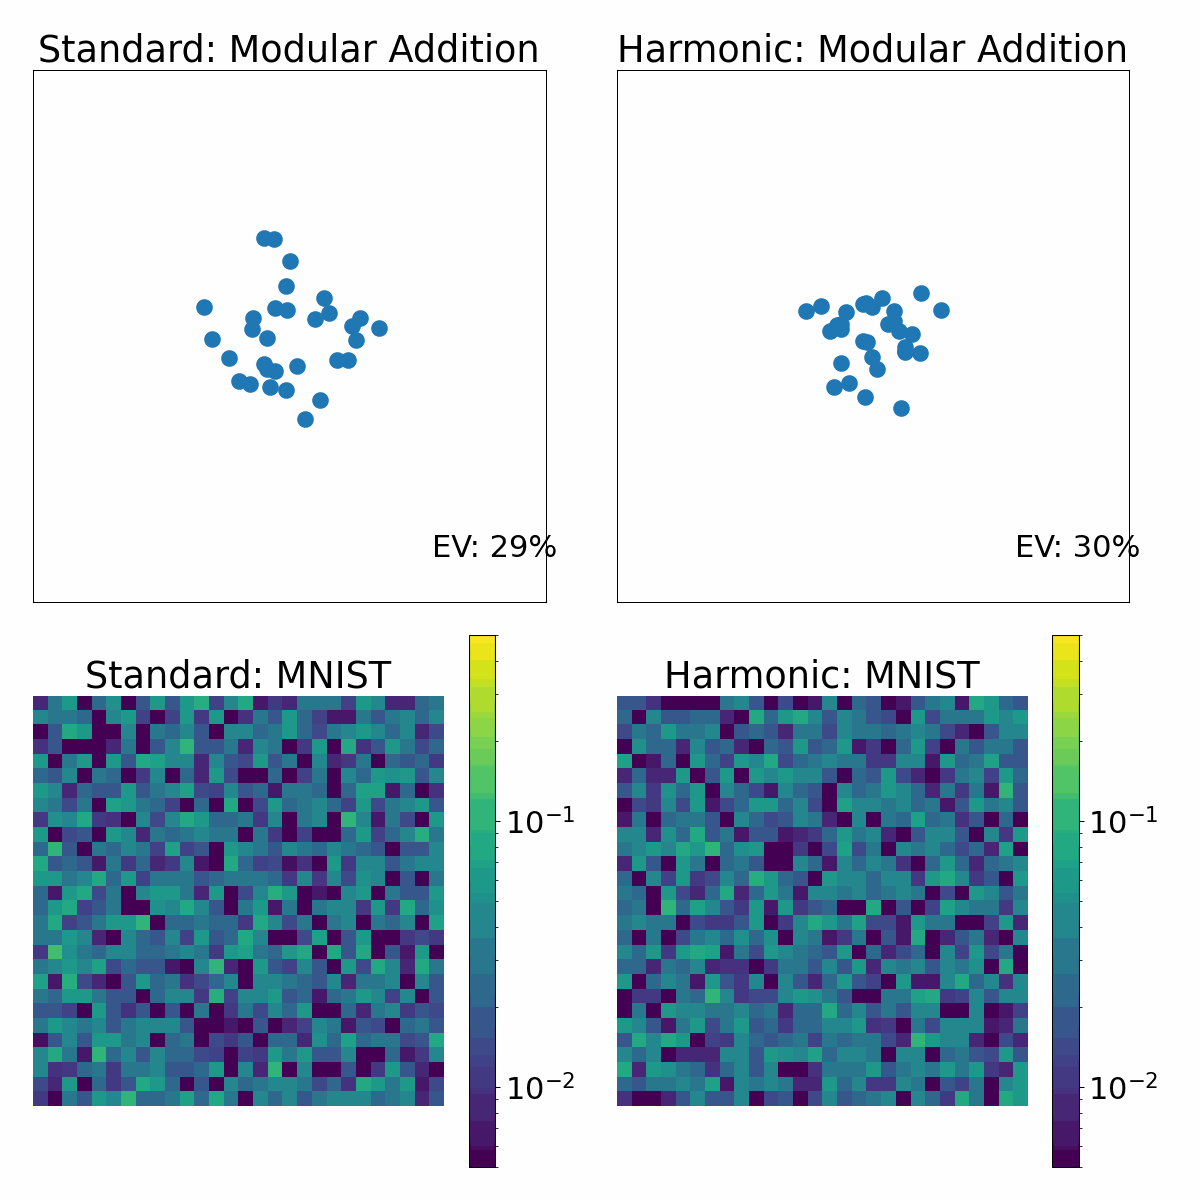

In [13]:
from IPython.display import Image

Image(filename="../figures/weights_evolution.gif")